In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

# load data

In [2]:
df_profiles = pd.read_csv('processed/profiles.csv')
print(df_profiles.shape)
df_profiles.head(6)

(4904, 11)


,id,is_closed,city,sex,followers_count,schools,schools_years_grad,universities,universities_years_grad,faculties,careers
0,1119,False,2.0,2,1256.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1127,False,2.0,2,2738.0,"['12', '3447', '59']","[2005, None, None]","[53, 53, 53]","[2011, 2014, 2012]","[201, 201, 169574]","[None, None, None, None, None, None, None]"
2,2619,True,2.0,2,NaN,"['54', '1319']","[2005, None]","[1, 29, 1]","[2010, 2011, 2013]","[7, 1815, 7]",[]
3,2767,False,2.0,2,446.0,"['12', '6972', '969864']","[2005, 2001, 1996]",[53],[2011],[201],[]
4,4023,False,2.0,2,462.0,"['54054', '11301']","[2002, 2002]","[53, 53]","[2008, 2011]","[202, 208]","[94, 94, None]"
5,18239,False,2.0,2,1887.0,['1739'],[None],[53],[None],[202],"[94, 76139618]"


In [3]:
df_posts = pd.read_csv('processed/posts.csv')
print(df_posts.shape)
df_posts.head(6)

(43979, 7)


,comments_count,attachments_count,views,likes,author_id,post_type,post_dttm
0,1,0,NaN,0.0,1119,post,1685912400
1,2,0,1402.0,24.0,1119,post,1664053200
2,3,0,852.0,8.0,1119,post,1647205200
3,7,1,1390.0,24.0,1119,post,1630702800
4,7,2,1819.0,14.0,1119,post,1612299600
5,3,0,741.0,9.0,1119,post,1611090000


In [4]:
df_friends = pd.read_csv('processed/friends.csv')
print(df_friends.shape)
df_friends.head(3)

(953179, 2)


,user1,user2
0,1119,9216
1,1119,3580931
2,1119,6055941


# make features

In [5]:
user2friends = df_friends.groupby('user1').user2.apply(set).to_dict()

In [6]:
def calc_feature(user1: int, user2: int) -> float:
    return np.random.random()

In [7]:
records = []
users = sorted(set(df_friends.user1.tolist()))
for i, u1 in tqdm(enumerate(users), total=len(users)):
    for j, u2 in enumerate(users):
        if j <= i: 
            continue
        records.append((
            u1, 
            u2,
            calc_feature(u1, u2)
        ))
        
df = pd.DataFrame(records, columns=['user1', 'user2', 'your_feature_name'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3759/3759 [00:03<00:00, 973.25it/s]


In [8]:
print(len(df))
df.head(3)

7063161


,user1,user2,your_feature_name
0,1119,1127,0.860916
1,1119,2619,0.018310
2,1119,2767,0.652498


# evaluate model

In [9]:
links_train = pd.read_csv('processed/links_train.csv')
links_test = pd.read_csv('processed/links_test.csv')

len(links_train), len(links_test)

(6356754, 706407)

In [10]:
train = links_train.merge(df, on=['user1', 'user2'], how='inner')
print(len(train))
train.head(3)

6356754


,user1,user2,is_friends,your_feature_name
0,82530889,157814259,0,0.795680
1,104274145,669799766,0,0.985787
2,227438304,268462283,0,0.158391


In [11]:
train, valid = train_test_split(train, test_size=0.2, stratify=train.is_friends)

In [12]:
test = links_test.merge(df, on=['user1', 'user2'], how='inner')
print(len(test))
test.head(3)

706407


,ID,user1,user2,your_feature_name
0,0,426512423,767230291,0.209695
1,1,127744839,589283004,0.083597
2,2,76324543,189101836,0.123471


In [13]:
features = [
    'your_feature_name'
]
target = 'is_friends'

In [14]:
model = LogisticRegression()
model = model.fit(train[features], train[target])

preds_train = model.predict_proba(train[features])
gt_train = train[target]

preds_valid = model.predict_proba(valid[features])
gt_valid = valid[target]

In [15]:
balanced_accuracy_score(gt_train, preds_train.argmax(axis=1))

0.5

# calc metrics

/Users/i.shamov/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/i.shamov/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


prec train: 0.000 valid: 0.000
recall train: 0.000 valid: 0.000
f1 train: 0.000 valid: 0.000
roc auc train: 0.503 valid: 0.501

balanced acc train: 0.500 valid: 0.500


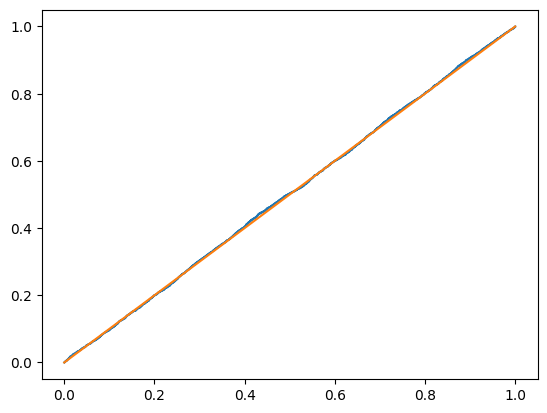

In [16]:
# params = dict(average='weighted')
params = dict()

print(f'prec train: {precision_score(gt_train, preds_train.argmax(axis=1), **params):.3f} valid: {precision_score(gt_valid, preds_valid.argmax(axis=1), **params):.3f}')
print(f'recall train: {recall_score(gt_train, preds_train.argmax(axis=1), **params):.3f} valid: {recall_score(gt_valid, preds_valid.argmax(axis=1), **params):.3f}')
print(f'f1 train: {f1_score(gt_train, preds_train.argmax(axis=1), **params):.3f} valid: {f1_score(gt_valid, preds_valid.argmax(axis=1), **params):.3f}')
print(f'roc auc train: {roc_auc_score(gt_train, preds_train[:, 1], **params):.3f} valid: {roc_auc_score(gt_valid, preds_valid[:, 1], **params):.3f}')

print(f'\nbalanced acc train: {balanced_accuracy_score(gt_train, preds_train.argmax(axis=1)):.3f} valid: {balanced_accuracy_score(gt_valid, preds_valid.argmax(axis=1)):.3f}')

fpr, tpr, tr = roc_curve(valid[target], preds_valid[:, 1])
_ = plt.plot(fpr, tpr)
_ = plt.plot((0, 1), (0, 1))

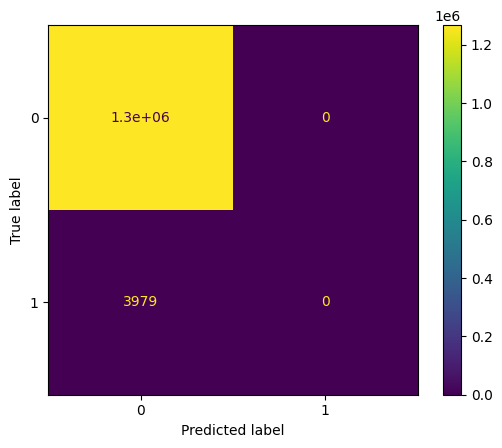

In [17]:
ConfusionMatrixDisplay(confusion_matrix(valid[target], preds_valid.argmax(axis=1))).plot()

# make solution

In [18]:
test_pred = model.predict_proba(test[features]).argmax(axis=1)
print('friends percentage: ', sum(test_pred) / len(test_pred))

friends percentage:  0.0


In [19]:
test_pred = test[['user1', 'user2']].assign(is_friends=test_pred)
test_pred.assign(ID=list(range(len(test_pred))))[['ID', 'is_friends']].to_csv('pred.csv', index=False)